In [1]:
import operator
from functools import reduce
from typing import List

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
import torch
from pyro import poutine
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.ops.indexing import Vindex
from torch.distributions import constraints

pyro.set_rng_seed(0)

# Purpose
- Reproducing [`fritzo`'s answer](https://forum.pyro.ai/t/model-based-machine-learning-book-chapter-2-skills-example-in-pyro-tensor-dimension-issue/464/12?u=bdatko) to [Chapter 2 MBML Learning skills](https://mbmlbook.com/LearningSkills.html)

The twist:
1. we are using `pyro.__version__ == 1.7.0` instead of `0.3`
1. assume a fixed guessing probability (work on building one the first iterations of the model from the book)
2. reporduce the results for just three questions, two skills using model form [**Figure 2.17**](https://mbmlbook.com/LearningSkills_Moving_to_real_data.html) with [**Table 2.4**](https://mbmlbook.com/LearningSkills_Testing_out_the_model.html), reproduced below

|    | IsCorrect1   | IsCorrect2   | IsCorrect2   |   P(csharp) |   P(sql) |
|---:|:-------------|:-------------|:-------------|------------:|---------:|
|  0 | False        | False        | False        |       0.101 |    0.101 |
|  1 | True         | False        | False        |       0.802 |    0.034 |
|  2 | False        | True         | False        |       0.034 |    0.802 |
|  3 | True         | True         | False        |       0.561 |    0.561 |
|  4 | False        | False        | True         |       0.148 |    0.148 |
|  5 | True         | False        | True         |       0.862 |    0.326 |
|  6 | False        | True         | True         |       0.326 |    0.862 |
|  7 | True         | True         | True         |       0.946 |    0.946 |

The table above can be used to check our model, and to get us ready for the *real data*. Lets view each permutation as a data record, resulting in a table of 3 responses from 8 people, where each question either needs `skill_01`, `skill_02`, or `skill_01` and `skill_02`. The toy data is shown below:

In [2]:
responses_check = torch.tensor([[0., 1., 0., 1., 0., 1., 0., 1.], [0., 0., 1., 1., 0., 0., 1., 1.], [0., 0., 0., 0., 1., 1., 1., 1.]])
skills_needed_check = [[0], [1], [0, 1]]

In [3]:
# row = participants' responses to each question
# column = participants
responses_check.shape

torch.Size([3, 8])

In [4]:
def model(graded_responses, skills_needed: List[List[int]], prob_mistake=0.1, prob_guess=0.2):
    n_questions, n_participants = graded_responses.shape
    n_skills = max(map(max, skills_needed)) + 1
    
    with pyro.plate("participants_plate", n_participants):
        with pyro.plate("skills_plate", n_skills):
            skills = pyro.sample("skills", dist.Bernoulli(0.5), )
            
    for q in pyro.plate("questions_plate", n_questions):
        has_skills = reduce(operator.mul, [skills[i] for i in skills_needed[q]]).float()
        prob_correct = (has_skills * (1 - prob_mistake) + (1 - has_skills) * prob_guess)
        isCorrect = pyro.sample("isCorrect{}".format(q), dist.Bernoulli(prob_correct).to_event(1), obs=graded_responses[q])

In [5]:
def guide(graded_responses, skills_needed: List[List[int]], prob_mistake=0.1, prob_guess=0.2):
    _, n_participants = graded_responses.shape
    n_skills = max(map(max, skills_needed)) + 1
    
    skill_p = pyro.param("skill_p", 0.5 * torch.ones(n_skills,n_participants), constraint=constraints.unit_interval)
    
    with pyro.plate("participants_plate", n_participants):
        with pyro.plate("skills_plate", n_skills):
            skills = pyro.sample("skills", dist.Bernoulli(skill_p))
            
    return skills, skill_p

In [6]:
# smoke test for guide
guide(responses_check, skills_needed_check)

(tensor([[1., 0., 1., 1., 1., 0., 1., 0.],
         [1., 0., 1., 1., 1., 1., 1., 0.]]),
 tensor([[0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000],
         [0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000, 0.5000]],
        grad_fn=<ClampBackward1>))

In [7]:
adam_params = {"lr": 0.05, "betas": (0.9, 0.999)}
optimizer = pyro.optim.Adam(adam_params)

In [8]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=model, guide=guide, optim=optimizer, loss=pyro.infer.Trace_ELBO())

losses, skills_svi = [], []
for t in range(10_000):
    losses.append(svi.step(responses_check, skills_needed_check))
    skills_svi.append(pyro.param("skill_p"))

In [9]:
d = pyro.get_param_store()

In [10]:
res_skill_0 = torch.vstack([s[0] for s in skills_svi])
res_skill_0 = res_skill_0.detach().numpy()
res_skill_0

array([[0.51249737, 0.51249737, 0.48750263, ..., 0.51249737, 0.48750263,
        0.51249737],
       [0.5111439 , 0.5111439 , 0.4750087 , ..., 0.5249913 , 0.48885608,
        0.5249913 ],
       [0.5067726 , 0.5067726 , 0.4694806 , ..., 0.5371534 , 0.49322742,
        0.5305194 ],
       ...,
       [0.07945157, 0.940372  , 0.02209679, ..., 0.8843498 , 0.35367662,
        0.9886127 ],
       [0.07912742, 0.9399194 , 0.02226795, ..., 0.8837418 , 0.35083267,
        0.98854584],
       [0.07893684, 0.93944186, 0.02244011, ..., 0.8830483 , 0.34681496,
        0.98847884]], dtype=float32)

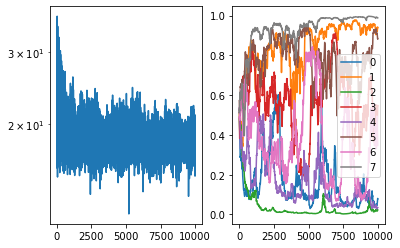

In [11]:
plt.subplot(1,2,1)
plt.semilogy(losses)

ax2 = plt.subplot(1,2,2)
for n in range(8):
    plt.plot(res_skill_0[:,n], label=str(n))
    
plt.legend()

In [12]:
res_skill_1 = torch.vstack([s[1] for s in skills_svi])
res_skill_1 = res_skill_1.detach().numpy()
res_skill_1

array([[0.48750263, 0.51249737, 0.51249737, ..., 0.48750263, 0.48750263,
        0.51249737],
       [0.48885608, 0.5111439 , 0.5249913 , ..., 0.4750087 , 0.48885608,
        0.5249913 ],
       [0.49322742, 0.5067726 , 0.5305194 , ..., 0.4694806 , 0.48624858,
        0.5371534 ],
       ...,
       [0.05672815, 0.00344691, 0.8466699 , ..., 0.08960518, 0.84103084,
        0.8718411 ],
       [0.05604482, 0.00341778, 0.84697336, ..., 0.08976293, 0.83969796,
        0.8731921 ],
       [0.05550299, 0.00339268, 0.84697396, ..., 0.09000763, 0.83818406,
        0.8741439 ]], dtype=float32)

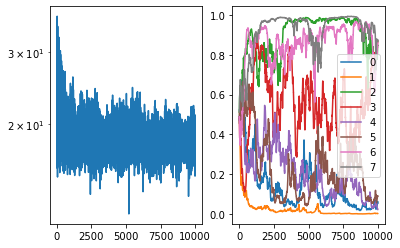

In [13]:
# same loss, skill_02
plt.subplot(1,2,1)
plt.semilogy(losses)

ax2 = plt.subplot(1,2,2)
for n in range(8):
    plt.plot(res_skill_1[:,n], label=str(n))
    
plt.legend()

## Expected Answer

In [14]:
expected = pd.DataFrame(
    [
        (False, False, False, 0.101, 0.101),
        (True, False, False, 0.802, 0.034),
        (False, True, False, 0.034, 0.802),
        (True, True, False, 0.561, 0.561),
        (False, False, True, 0.148, 0.148),
        (True, False, True, 0.862, 0.326),
        (False, True, True, 0.326, 0.862),
        (True, True, True, 0.946, 0.946),
    ],
    columns=["IsCorrect1", "IsCorrect2", "IsCorrect2", "P(csharp)", "P(sql)"],
)
expected

,IsCorrect1,IsCorrect2,IsCorrect2,P(csharp),P(sql)
0,False,False,False,0.101,0.101
1,True,False,False,0.802,0.034
2,False,True,False,0.034,0.802
3,True,True,False,0.561,0.561
4,False,False,True,0.148,0.148
5,True,False,True,0.862,0.326
6,False,True,True,0.326,0.862
7,True,True,True,0.946,0.946


In [15]:
expected["SVI skill_01 P(csharp)"] = res_skill_0[-1, :]
expected["SVI skill_02 P(sql)"] = res_skill_1[-1, :]

In [16]:
expected

,IsCorrect1,IsCorrect2,IsCorrect2,P(csharp),P(sql),SVI skill_01 P(csharp),SVI skill_02 P(sql)
0,False,False,False,0.101,0.101,0.078937,0.055503
1,True,False,False,0.802,0.034,0.939442,0.003393
2,False,True,False,0.034,0.802,0.022440,0.846974
3,True,True,False,0.561,0.561,0.547225,0.868830
4,False,False,True,0.148,0.148,0.034718,0.023729
5,True,False,True,0.862,0.326,0.883048,0.090008
6,False,True,True,0.326,0.862,0.346815,0.838184
7,True,True,True,0.946,0.946,0.988479,0.874144
